# Bayesian Analysis of Clinical Scenario in "Don't Drop The Anchor" by Manesh, R.S., et. al. (2014)

### Introduction

In [3]:
import pymc3 as pm
import arviz as az
import numpy as np

In [11]:
def run_model():
    likelihood_ca19_9 = 0.25
    likelihood_fna = 0.11
    certainty = 1
    alpha = 9 * certainty
    beta = 1 * certainty
    mean_prior = alpha / (alpha + beta)
    var_prior = (alpha * beta) / (np.power(alpha + beta, 2) * (alpha + beta + 1))

    with pm.Model() as model:
        # pre_test prob 1
        p_1 = pm.Beta('p_1', alpha=alpha, beta=beta)
        # p_1 = pm.Uniform('p_1')
        o_1 = pm.Deterministic('o_1', (p_1 / (1 - p_1)))
        #l_ca19_9 = pm.HalfNormal('l_ca19_9', sigma=likelihood_ca19_9)
        l_ca19_9 = pm.Normal('l_ca19_9', mu = likelihood_ca19_9, sigma=0.05)


        # prob after CA-19-9
        o_2 = pm.Deterministic('o_2', o_1 * l_ca19_9)
        p_2 = pm.Deterministic('p_2', o_2 / (o_2 + 1))

        # prob after FNA
        l_fna = pm.HalfNormal('l_fna', sigma=likelihood_fna)
        o_3 = pm.Deterministic('o_3', o_2 * l_fna)
        p_3 = pm.Deterministic('p_3', o_3 / (o_3 + 1))

        model_trace = pm.sample(cores=1, chains=1, draws=10000)
    
    return model_trace

In [12]:
model_trace = run_model()

/Users/johnwilliam/Dropbox/TPG/reza_analysis/venv/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [l_fna, l_ca19_9, p_1]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 9 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


/Users/johnwilliam/Dropbox/TPG/reza_analysis/venv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/johnwilliam/Dropbox/TPG/reza_analysis/venv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/johnwilliam/Dropbox/TPG/reza_analysis/venv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Ma

array([[<AxesSubplot:title={'center':'p_1'}>,
        <AxesSubplot:title={'center':'p_1'}>],
       [<AxesSubplot:title={'center':'p_2'}>,
        <AxesSubplot:title={'center':'p_2'}>],
       [<AxesSubplot:title={'center':'p_3'}>,
        <AxesSubplot:title={'center':'p_3'}>]], dtype=object)

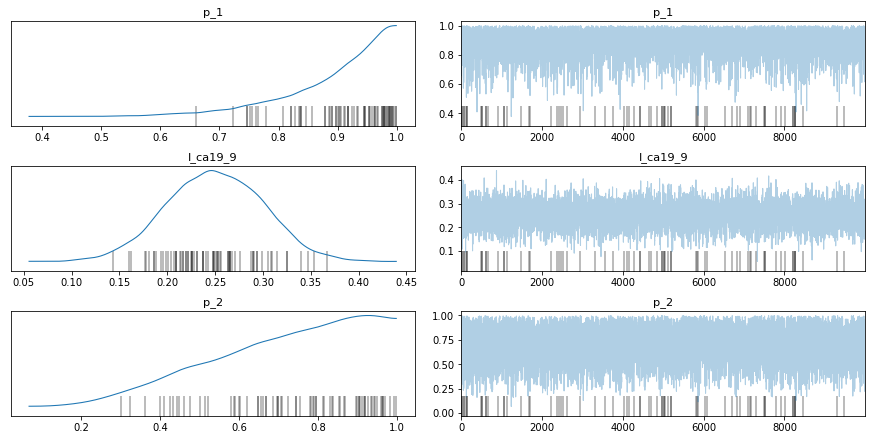

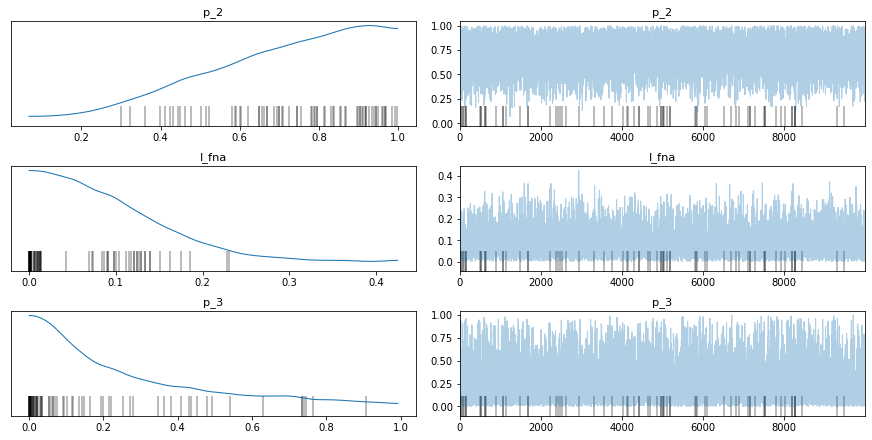

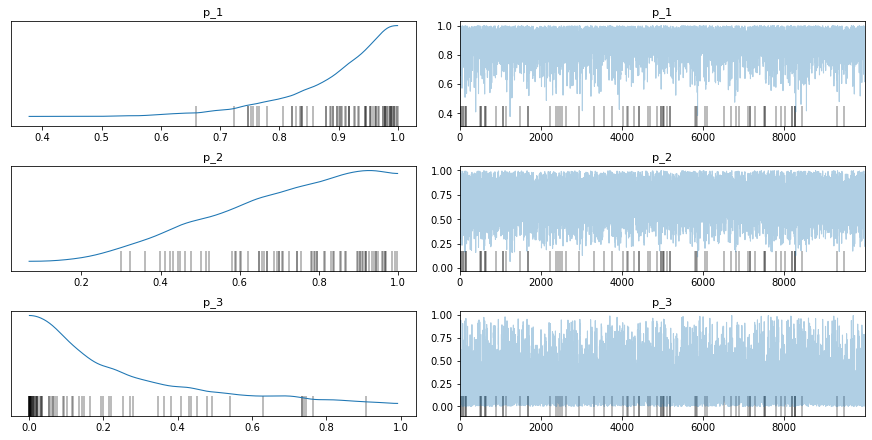

In [13]:
az.plot_trace(model_trace,var_names=['p_1','l_ca19_9','p_2'])
az.plot_trace(model_trace,var_names=['p_2','l_fna','p_3'])
az.plot_trace(model_trace,var_names=['p_1','p_2','p_3'])